# Synthetic expression data from cellular reprogramming network

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import random
from colomoto.minibn import * # for Boolean network manipulation
import networkx as nx # for graph manipulation
from scboolseq import scBoolSeq

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from plotnine import *

# set seed for reproducible results
_rng_seed = 19834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)
random.seed(_rng_seed)

In [3]:
%matplotlib inline

## Load Boolean network

In [4]:
bn = BooleanNetwork.load("models/reprogramming.bnet")
bn

G1 <- TF1
G2 <- TF1
G3 <- TF1
G4 <- TF2
G5 <- TF2
G6 <- TF2
G7 <- TF6
G8 <- TF6
G9 <- TF6
TF1 <- TF3&!TF2
TF2 <- TF3&!TF1
TF3 <- TF4
TF4 <- TF5
TF5 <- !TF6
TF6 <- !TF7
TF7 <- 1

# computing graph layout...


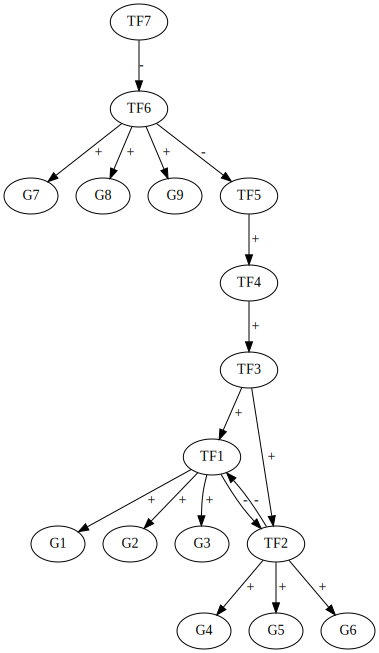

In [5]:
bn.influence_graph()

## Extract trajectories from the state transition graph

We consider the initial state where TF6 (and related G7-G9 genes) are active, as well as TF7 which will trigger the reprogramming.

In [6]:
initial_state = bn.zero()
for node in ["TF7", "TF6", "G7", "G8", "G9"]:
    initial_state[node] = 1
initial_state

{'G1': 0,
 'G2': 0,
 'G3': 0,
 'G4': 0,
 'G5': 0,
 'G6': 0,
 'G7': 1,
 'G8': 1,
 'G9': 1,
 'TF1': 0,
 'TF2': 0,
 'TF3': 0,
 'TF4': 0,
 'TF5': 0,
 'TF6': 1,
 'TF7': 1}

We compute the state transition graph from the initial state, using the fully asynchronous update mode:

# computing graph layout...


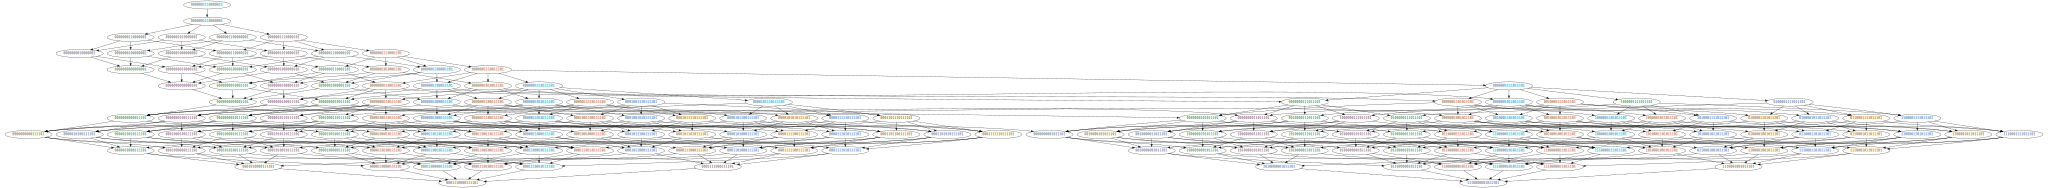

In [7]:
dynamics = FullyAsynchronousDynamics(bn)
stg = dynamics.partial_dynamics(initial_state)
stg

We can observe two stables states, both sharing TF7, and TF3-TF5 active, and one corresponding to TF1 active (and G1-G3), and one corresponding to TF2 (and G4-G6) active; the branching point is the state just before the activation of either TF1 or TF2.
The deactivation of G1-G3 (resulting from the deactivation of TF6) is interleaved with the differentiation process. Thus the bifurcation point is not uniquely determined as in the previous example.


In [8]:
# utility function to query the state-transition graph
def node_of_state(state):
    # convert a dict state to the binary representation
    return "".join([str(state[node]) for node in dynamics.nodes])
def extract_state(name):
    # convert the binary representation of a state to a dict
    return dict(zip(dynamics.nodes, map(int, name)))

init = node_of_state(initial_state)
print(f"{init=}")
branching_active = ["TF7", "TF3", "TF4", "TF5"]
branching = node_of_state({n: int(n in branching_active) for n in bn})
print(f"{branching=}")

init='0000001110000011'
branching='0000000000011101'


We get the two stable states by computing the attractors of the state-transition graph:

In [9]:
stables = [list(A)[0] for A in nx.attracting_components(stg)]
stables.sort()
stables # [0] is with TF2 active and [1] is with TF1 active

['0001110000111101', '1110000001011101']

Trajectory from initial state to first stable state:

In [10]:
common = nx.shortest_path(stg, init, branching)
traj1 = nx.shortest_path(stg, branching, stables[1])[1:]
traj2 = nx.shortest_path(stg, branching, stables[0])[1:]
binstates = pd.DataFrame(map(extract_state, common+traj1+traj2))

# label the states
labels = [f"common.{i}" for i in range(len(common)-1)] + ["switch"]\
         + [f"branch1.{i}" for i in range(len(traj1)-1)] + ["stable1"] \
         + [f"branch2.{i}" for i in range(len(traj2)-1)] + ["stable2"]
binstates.index = labels
binstates.index.name = "label"

binstates

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
label,,,,,,,,,,,,,,,,
common.0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1
common.1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1
common.2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
common.3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1
common.4,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1
common.5,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,1
common.6,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1
switch,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1
branch1.0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1


We select the common path and two paths from the branching state to the stable states:

## Retrieve reference dataset

In [11]:
%ls data_filtered_vargenes/*csv

data_filtered_vargenes/GSE122466_Retina.csv
data_filtered_vargenes/GSE122466_Retina_vargenes_batch1.csv
data_filtered_vargenes/GSE130973_human_skin.csv
data_filtered_vargenes/GSE156234_Macrophages.csv
data_filtered_vargenes/GSE60361_mouse_brain.csv
data_filtered_vargenes/GSE81682_Hematopoiesis.csv


In [12]:
ref_data = pd.read_csv("data_filtered_vargenes/GSE81682_Hematopoiesis.csv", index_col=0)
ref_data.head()

,8430408G22Rik,Plp1,Zfp947,Bhlhb9,Vps35,Slc18a1,Fam107b,Gm14230,Plekhn1,Ankrd6,9030619P08Rik,Prtn3,Lrrn4,Mrgpre,Gm25926,Plppr3,Memo1,Cdkn1c,Gm2a,Phxr4,B2m,Tbxas1,Glipr2,Tcf15,Trim58,D930028M14Rik,1700010I14Rik,Gm10384,Sla2,Trp53i13,Gm17586,Gypc,Clic5,Tubb4b,AC149090.1,Gm26580,Clec1a,Ccl9,Gimap3,Zscan18,Spi1,Ccl6,2900041M22Rik,Klk8,Gm37637,Gp9,Idh3a,Akr1c13,2810408A11Rik,Npr2,Ephx1,Pik3ip1,ENSMUSG00000043858,Gm26789,Grina,Txnip,Gm26541,Dnajb3,Msn,Gm37124,Srd5a1,Bhlhe40,Pomgnt2,Fcer1g,Gm37298,Lmo1,Rab20,Cd69,Gm2788,Gm14276,Napa,Cd24a,Nsun2,Marveld2,Ms4a4b,Gm17590,Cdk6,Tada2b,Gm5113,Mki67,Btg2,Gnat2,Tcaf1,Slc35e4,Reep2,8430419K02Rik,Pdgfd,H2-K1,Sesn1,Bcap29,Gm21814,Eif5a,Stk25,Maged1,Zfp449,9130604C24Rik,6430590A07Rik,Tcirg1,Il4,Slc35a4,Cysltr2,Ap3m2,Dsel,Cmtm7,Arl8b,Gbx2,Smim10l2a,Cyth4,S1pr4,Gdi1,Hdhd3,Vill,Slc38a6,Calu,Gm16565,Smim3,Sar1a,4833407H14Rik,B230217O12Rik,Ccdc39,Spata2l,Arxes2,Dut,Ifngr1,Rasa3,Fbxl2,Pde4b,Ptp4a3,Cdt1,Fxyd1,Arl11,Shisa8,Dleu7,Tmem173,Atxn10,Rpn2,Ccl3,Nudt16,Kif3c,Hars,Ccl4,Myo1g,Cpq,Cox6a2,Sdc3,Dok2,Fcgrt,Elmo1,Cyc1,Calr,Gpr18,Tbxa2r,Gpr183,Naaa,Gm11110,Alad,Taz,Echdc3,Cd300a,Slc39a4,Zfp128,Gm26819,Ispd,Itm2b,Zfp647,Gm16861,Nek3,Gata2,Prss16,Lppos,Lhcgr,Fundc1,Lat,Tnfrsf26,Prr36,Vldlr,Mfge8,Enkur,Rcor2,Ndn,Btla,Zyx,Cd33,Dkc1,Rab37,Cdcp1,Hoxa9,Oat,Vegfc,Gas6,Oasl2,Tacc1,Colgalt1,Xdh,Rab32,Dusp2,Tmem176a,Gnai3,Rnf13,Elane,Cd48,Mthfd1,Igkc,Fnta,Bok,Ripply3,Ptger2,P2rx7,Wdfy2,Eif1a,Gstm7,Tmem14c,2900018N21Rik,Mpl,Sash3,Tgm2,Gm19569,Ehd3,Cish,Calml4,Mesdc2,Nfil3,Tcn2,Saraf,Meis1,Serpina3g,Pcx,Gpr171,Cks1b,Coa5,Arhgap27os3,Farsa,Ctsl,Iigp1,P2ry14,Cd82,Slc18a2,Cd302,Parp12,Isyna1,S100a8,B130034C11Rik,Arhgap27,Klf1,Gm26740,Cd84,Bag2,Tmem123,Emilin1,4930568A12Rik,Clec11a,Mat2a,Tespa1,Wfdc17,Tspan13,Dyrk2,S100a9,F10,Pde1b,Gcnt2,Ppic,Zfp72,Gm4841,Ckb,C130013H08Rik,Spo11,Ctss,Vwa5a,Serpinb1a,Trib3,Slc28a2,Xbp1,Tsc22d3,Cd74,Nhlrc1,Rac2,Il15,Ift43,Tnfrsf13c,Gm10451,Plod2,Minpp1,Cs,Gm21967,Trim27,Rrm1,Krt18,Rap1b,Anxa2,D130040H23Rik,Tmsb4x,1810034E14Rik,2810021J22Rik,F630028O10Rik,Cyb5r3,B3gnt3,Laptm5,Adam11,Rab17,Pkia,Hist3h2ba,Cyp27a1,Zfp36,Mcm5,Ssc4d,Gm45837,Lmcd1,Fgf3,Car1,Adssl1,Il21r,Slc50a1,Serpinb9,Pttg1ip,Fam83d,Tspan32,Tnfrsf13b,Gdi2,Nim1k,Mapk12,Wfdc18,Thbs1,Chil5,Mpst,Selenop,Gm43852,Hk3,Irgm1,Nceh1,Myl10,Tmx1,Zcchc24,Acsl5,Tnfaip8,4632427E13Rik,Hspa9,Hid1,Gstt1,Il12rb1,Ficd,Bbs10,Esam,Unc93b1,Casp4,F2r,Dynlt3,Adgrg1,Tmem38a,Stap1,Cep170b,Lpxn,Frmd8,Doc2g,Ighv1-23,Hrh2,Bgn,Ifi206,Fes,Apol7e,Srl,Ifi47,Cdca7,Srm,Smagp,Zfp418,Zfp882,Mmp2,Fam32a,Flna,Lyz2,Cd53,Mapk11,Sptbn1,Mapre3,Nr0b2,Ptprc,Gulp1,Cd63,Nsg1,Fam131a,Dntt,Ifi213,Tcp1,Stard8,Clptm1l,Sigirr,Robo3,Il17rb,Mcfd2,Vpreb1,Casp12,Zbtb3,Ppt1,H1f0,C730034F03Rik,Tpst2,Pnrc1,Sdhaf2,Hnrnpdl,Cyp7b1,Ptpre,Slc25a45,Wdr35,Capg,Sf3b3,Gata1,Spry1,Abce1,Rnf180,Golph3l,P2ry10,Adgrg3,Fkbp4,F2rl2,Gbp2,Plcg2,Ccdc189,4930486L24Rik,E230001N04Rik,Itih5,Chrnb1,Gm16386,Thnsl2,Gm16712,Top2a,Gm5577,Nt5c3,Nlrp10,Ctf1,Il18bp,Il1rl2,Gm5148,Car2,Vim,A630033H20Rik,Cd81,Zfp563,Ctla2a,Mfsd2b,Idh2,Tert,Pwwp2b,Atp6ap2,Ces2g,Gba2,4931428F04Rik,Apoe,Sdha,Dlg3,Igkv4-50,Dhx58,Zfp661,Ccr9,Rgs2,Ctsc,Parp8,Tspo2,5430420F09Rik,Pear1,Ltb,Gm26512,AA467197,Unc5cl,Mtpn,Mcm6,Atp2a3,Tyms,Il12a,Celf2,Axl,Tpm4,Gm3739,Cyp2j9,Fxyd5,B230216N24Rik,Trbc2,Fam161b,Gm30948,Apbb1,Igfbp4,Pcp4l1,Rassf5,Cyp2r1,Smoc1,Srgn,Pygm,Gm43200,Gca,Arhgef6,Fah,BC017643,Ak3,Icam1,Gm10505,C1qbp,Efna1,AW112010,Tnks1bp1,Anxa1,Fgf11,Layn,Gm19331,Rbpms2,Tspan3,Ighv9-1,Gm43201,Arrdc1,Hjurp,4921507P07Rik,Sla,Ms4a6b,Zfp551,2810468N07Rik,Tnf,Serp1,Mfap2,Arhgef18,Slc25a29,Hmox1,Pkm,Arhgap15,Ddx39,Fv1,Gnb5,Tes,Lysmd2,Mmp11,Pgrmc1,Gm42979,Efna4,Uba7,Xist,Sumo3,Flt3,Mycn,1300017J02Rik,Scn1b,Rab38,ENSMUSG00000096970,Tnfaip2,Hdac2,Ccr7,Irf6,Mndal,Fut4,Casp1,Slc14a1,Rit1,Ifi203,Zfp93,Calr3,2210010C04Rik,Gm38243,Gm43313,Slc25a5,Bcam,Ighv1-74,Traf3ip3,Lgals9,Gm26982,Clec10a,Klhl8,Islr,Ighv1-76,Crlf3,Ighv1-77,Lcp2,Rapsn,Cd38,Gm37423,Selplg,Clip3,Ccdc157,Uggt2,Mpo,Eya1,Ctso,Gm26917,Rarb,Cmtm6,Metrnl,Rgs1,Ptpn6,Cd1d1,Lyrm1,Prkaa2,Gm4759,Aplp

In [13]:
%time scbool = scBoolSeq().fit(ref_data)
scbool

Computing bimodality index for 475/1165 genes
Computing bimodality index for 757/1165 genes
CPU times: user 1min 10s, sys: 1.97 s, total: 1min 12s
Wall time: 12 s


scBoolSeqBinarizer()

## Generate synthetic RNA-Seq data

In [14]:
SEED = 1928327465
n_samples = 200
synth_pseudocounts = scbool.sample_counts(binstates, n_samples_per_state=n_samples, random_state=SEED)

In [15]:
synth_pseudocounts.shape

(3200, 16)

We generate unique identifiers for each row (cell):

In [16]:
ids = [f"{x}_{y}"  for y in range(n_samples) for x in binstates.index]
synth_pseudocounts.index = ids
synth_pseudocounts.index.name = "cellID"
synth_pseudocounts

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
cellID,,,,,,,,,,,,,,,,
common.0_0,0.847507,0.000000,0.00000,2.202036,2.614669,0.000000,9.352732,10.004515,0.963155,4.002708,2.489920,4.472291,4.386781,6.781031,0.630191,15.730247
common.1_0,0.321988,0.000000,0.00000,0.000000,0.000000,0.000000,10.117821,9.609912,2.106883,3.590391,0.550599,4.498179,4.402592,6.796882,0.000000,15.391955
common.2_0,0.000000,0.200185,0.00000,1.383530,6.155153,0.000000,8.324763,8.316448,0.000000,4.271854,2.632206,3.231189,2.714706,6.547808,0.000000,16.391708
common.3_0,0.000000,0.000000,0.00000,0.000000,0.000000,0.067945,8.223393,9.823405,0.000000,4.304159,1.624660,4.489941,4.416064,15.693726,0.000000,15.618268
common.4_0,0.000000,0.000000,0.00000,0.192171,0.000000,0.000000,10.799113,9.326198,0.000000,3.920434,0.000000,1.386326,10.849850,11.264220,0.204638,15.620454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stable1_199,4.547110,0.639021,1.36129,3.077207,2.026706,0.000000,1.959658,0.000000,0.372315,11.297931,0.599283,12.413190,9.778069,9.765420,0.000000,16.297468
branch2.0_199,1.351856,0.000000,0.00000,3.434270,0.000000,0.000000,2.644374,1.170639,0.000000,3.287509,6.938048,7.827090,7.870819,10.638463,0.000000,16.106609
branch2.1_199,0.000000,0.000000,0.00000,7.470441,0.000000,0.176651,2.826096,0.000000,0.000000,2.880611,7.974349,7.897861,7.113470,10.292293,0.000000,15.975887


Write as TSV file:

In [17]:
synth_pseudocounts.T.to_csv("synthetic_data_reprogramming_counts.tsv", sep="\t")

We generate metadata to validate a trajectory reconstruction:

In [18]:
def label_of_index(idx):
    return idx.split(".")[0]
labels = [label_of_index(idx) for idx in binstates.index]

color_map = {
    "common": "#aec7e8",
    "switch": "#1f78b4",
    "branch1": "#98df8a",
    "stable1": "#2ca02c",
    "branch2": "#ff9896",
    "stable2": "#d62728"
}

In [19]:
metadata = [[l, color_map[l]] for l in labels]*n_samples
metadata = pd.DataFrame(metadata, columns=["label", "label_color"])
metadata.index = synth_pseudocounts.index
metadata

,label,label_color
cellID,,
common.0_0,common,#aec7e8
common.1_0,common,#aec7e8
common.2_0,common,#aec7e8
common.3_0,common,#aec7e8
common.4_0,common,#aec7e8
...,...,...
stable1_199,stable1,#2ca02c
branch2.0_199,branch2,#ff9896
branch2.1_199,branch2,#ff9896


In [20]:
metadata.to_csv("synthetic_data_reprogramming_metadata.tsv", sep="\t")

In [21]:
%time synth_scbool = scBoolSeq().fit(synth_pseudocounts)

Computing bimodality index for 8/16 genes
Computing bimodality index for 8/16 genes
CPU times: user 2.42 s, sys: 1.2 s, total: 3.61 s
Wall time: 411 ms


In [22]:
synth_scbool.criteria_.Category.value_counts()

Category
Bimodal     8
ZeroInf     6
Unimodal    2
Name: count, dtype: int64

<Axes: xlabel='Mean', ylabel='Variance'>

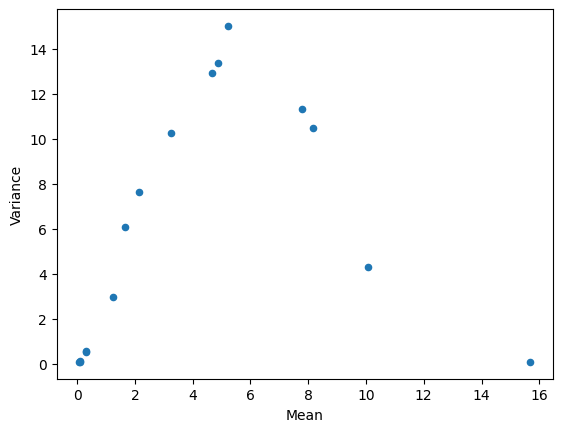

In [23]:
synth_scbool.criteria_.plot.scatter(x="Mean", y="Variance")

<Axes: xlabel='Mean', ylabel='DropOutRate'>

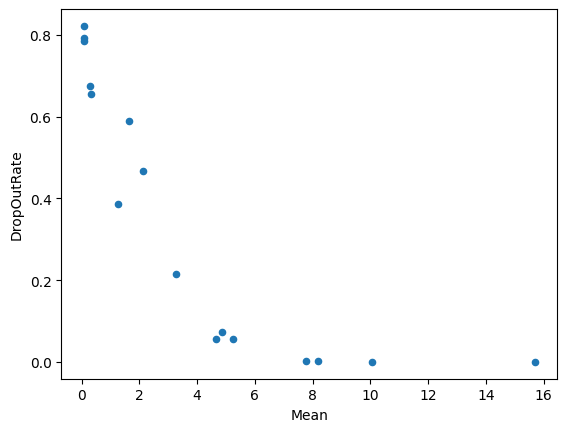

In [24]:
synth_scbool.criteria_.plot.scatter(x="Mean", y="DropOutRate")

In [25]:
from sklearn.manifold import TSNE

In [26]:
from sklearn.pipeline import Pipeline, FunctionTransformer

In [27]:
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding

In [28]:
def rename_columns(df):
    """ """
    df.columns = [f"dim{i}" for i in range(df.shape[1])]
    return df

In [29]:
vis_pipeline = Pipeline([
    ('pca', PCA()),
    ('subset_pca', FunctionTransformer(lambda x: x.iloc[:, :4])),
    ('lle', LocallyLinearEmbedding(n_neighbors=300, n_components=2, random_state=SEED)),
    ('rename_cols', FunctionTransformer(rename_columns))
])

In [30]:
%time aa = vis_pipeline.fit_transform(synth_pseudocounts)

CPU times: user 35.9 s, sys: 1min 28s, total: 2min 4s
Wall time: 8.66 s


In [31]:
aa

,dim0,dim1
cellID,,
common.0_0,-0.023993,0.000210
common.1_0,-0.026029,0.004916
common.2_0,-0.024219,-0.001533
common.3_0,-0.019266,0.004169
common.4_0,-0.020389,0.006781
...,...,...
stable1_199,0.020962,0.021574
branch2.0_199,0.008771,-0.014117
branch2.1_199,0.010626,-0.025348


In [32]:
vis_frame = aa.join(metadata)
vis_frame.index.name = "index"
vis_frame = vis_frame.reset_index().drop("index", axis="columns")
vis_frame.head()

,dim0,dim1,label,label_color
0,-0.023993,0.000210,common,#aec7e8
1,-0.026029,0.004916,common,#aec7e8
2,-0.024219,-0.001533,common,#aec7e8
3,-0.019266,0.004169,common,#aec7e8
4,-0.020389,0.006781,common,#aec7e8


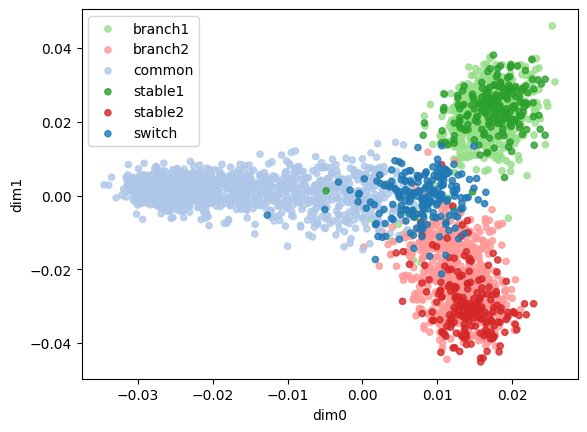

In [33]:
ax = None
for label, frame in vis_frame.groupby('label'):
    scatter_kwargs = dict(x='dim0', y='dim1', label=label, c=frame['label_color'], alpha=.8)
    if ax is not None:
        scatter_kwargs.update({'ax': ax})
    ax = frame.plot.scatter(**scatter_kwargs)



fig = ax.get_figure()
for _f in ['svg', 'pdf', 'png']:
    fig.savefig(f"reprogramming_network.{_f}")